In [97]:
using Plots, Flux, DataFrames, CSV, ProgressMeter, Statistics
import MLUtils: splitobs
import BSON: @save
max_epochs = 100
frac_train = 0.5
with_cat_arr = false

false

In [98]:
df  = CSV.read("data/Landslides.csv", DataFrame)
display(df)

Row,dist_roads,DEM,TWI,plan_curvature,profil_curvature,Slope,Geology,LandCover,LS
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64
1,90.1388,957.1,10.0174,0.00257542,1.56e-5,11.0455,2,41,0
2,282.843,536.1,9.21162,-0.00012923,-0.000289093,3.57188,1,21,0
3,90.1388,768.1,10.0824,0.00623542,-0.00240442,44.0343,2,41,0
4,79.0569,449.4,7.35267,0.00420136,0.00116142,11.3254,24,21,1
5,25.0,784.8,8.60168,0.00208871,-0.00271119,19.0155,1,41,1
6,25.0,991.5,13.7942,-0.00129205,0.00126791,8.28275,9,21,0
7,35.3553,569.2,8.86016,-0.00346738,0.00069258,23.9199,24,31,1
8,70.7107,1211.4,9.46106,-0.00180184,-0.00452195,21.2627,9,21,0
9,413.824,1592.5,8.28995,-0.00207019,0.00560989,38.1138,7,31,1


In [99]:
LandCover = Flux.onehotbatch(Array(df[:,8]), unique(Array(df[:,8])))
Geology   = Flux.onehotbatch(Array(df[:,7]), unique(Array(df[:,7])))
@show unique(Array(df[:,7]))
@show unique(Array(df[:,8]))

unique(Array(df[:, 7])) = [2, 1, 24, 9, 7, 11, 31, 36, 10]
unique(Array(df[:, 8])) = [41, 21, 31, 11, 51, 15, 62]


7-element Vector{Int64}:
 41
 21
 31
 11
 51
 15
 62

In [101]:
# Extract data
if with_cat_arr
    X_all  = [Array(df[:,1:6])'; Geology; LandCover ]
else
    X_all  = Array(df[:,1:6])'
end
n_data =size(X_all,1)

y_all       = df[:,9].==1

isplit      = Int(floor(size(X_all,2)*frac_train))
labels_TF   = [true, false]
# Training set:
noisy       = X_all[1:n_data,1:isplit]    # 6×1000 Matrix{Float32}
truth       = y_all[1:isplit]  #   1000-element Vector{Bool}
noisy[1:6,:]      .= Flux.normalise(noisy[1:6,:])
target      = Flux.onehotbatch(truth, labels_TF)                          # OneHotMatrix
loader      = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
# # Testing set:
noisy_test  = X_all[1:n_data,isplit+1:end]    # 6×1000 Matrix{Float32}
truth_test  = y_all[isplit+1:end]  #   1000-element Vector{Bool}
noisy_test[1:6,:]  .= Flux.normalise(noisy_test[1:6,:])
target_test = Flux.onehotbatch(truth_test, labels_TF)                   # 2×1000 OneHotMatrix
loader_test = Flux.DataLoader((noisy_test, target_test), batchsize=64, shuffle=true);

# # Split with multiple arrays and shuffling
# train, test = splitobs((X_all, y_all), at=frac_train, shuffle=true)
# X_train, Y_train = train
# X_test,  Y_test  = test
# noisy       = Flux.normalise(X_train)
# truth       = Y_train
# target      = Flux.onehotbatch(Y_train, [true, false]) 
# noisy_test  = Flux.normalise(X_test)
# truth_test  = Y_test
# target_test = Flux.onehotbatch(Y_test, [true, false]) 

BoundsError: BoundsError: attempt to access 6×5185 adjoint(::Matrix{Float64}) with eltype Float64 at index [9, 1:2592]

In [102]:
# Contruct neural network
if with_cat_arr
    model = Chain(
        Dense(22 => 45, tanh),   # activation function inside layer
        BatchNorm(45),
        Dense(45 => 2),
        softmax) 
else
    model = Chain(
        Dense(6 => 25, tanh),   # activation function inside layer
        BatchNorm(25),
        Dense(25 => 2),
        softmax) 
end

Chain(
  Dense(6 => 25, tanh),                 # 175 parameters
  BatchNorm(25),                        # 50 parameters, plus 50
  Dense(25 => 2),                       # 52 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 277 parameters,
          # plus 2 non-trainable, 50 parameters, summarysize 1.754 KiB.

In [103]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
loader                = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);
loss1(model, x, y)    = Flux.crossentropy(model(x), y);                  # Define the loss 
accuracy(model, x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y)) # Define the accuracy 
pars                  = Flux.params(model)                               # contains references to arrays in model
opt                   = Flux.Adam(0.05)                                  # will store optimiser momentum, etc.

Adam(0.05, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [104]:
# Pre-training
out1 = model( noisy );
@show loss1(model, noisy, target)
@show accuracy(model, noisy, target)

loss1(model, noisy, target) = 0.9323609385506444
accuracy(model, noisy, target) = 

0.28125


0.28125

In [105]:
# Training loop, using the whole data set 1000 times:
losses          = []
accuracies      = []
losses_test     = []
accuracies_test = []
for epoch in 1:max_epochs #@showprogress 
    for (x, y) in loader
        loss, grad = Flux.withgradient(pars) do
            # Evaluate model and loss inside gradient context:
            y_hat = model(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(opt, pars, grad)
        #########
        push!(losses, loss)  # logging, outside gradient context
        accu = accuracy(model, noisy, target)
        push!(accuracies, accu)
        #########
        loss_test = loss1(model, noisy_test, target_test)
        push!(losses_test, loss_test)  # logging, outside gradient context
        accu_test = accuracy(model, noisy_test, target_test)
        push!(accuracies_test, accu_test)
    end
end

DimensionMismatch: DimensionMismatch: A has dimensions (25,6) but B has dimensions (22,2593)

In [106]:
@show loss1(model, noisy, target)
@show accuracy(model, noisy, target)
out2 = model(noisy)  # first row is prob. of true, second row p(false)
mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

loss1(model, noisy, target) = 0.8035393263382915
accuracy(model, noisy, target) = 0.29282407407407407


0.29282407407407407

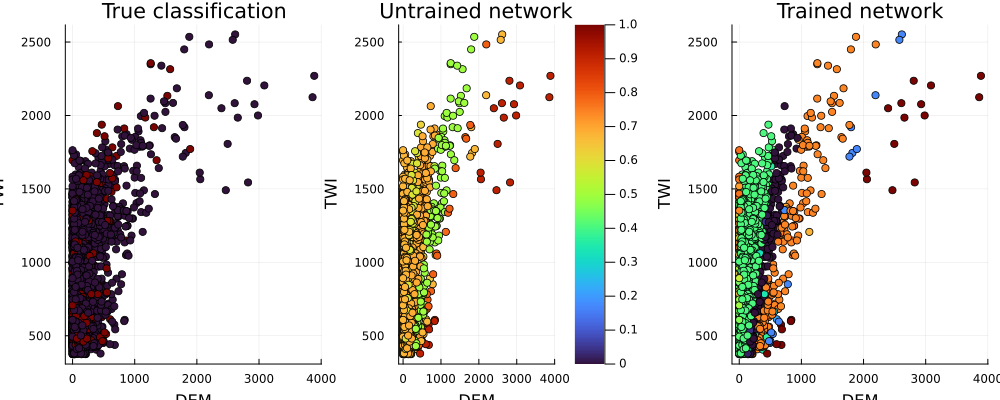

In [107]:
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth,     title="True classification", legend=false, c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1), c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false, c=:turbo, xlabel=names(df)[2], ylabel=names(df)[3] )
plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,400))

n = length(loader) = 41


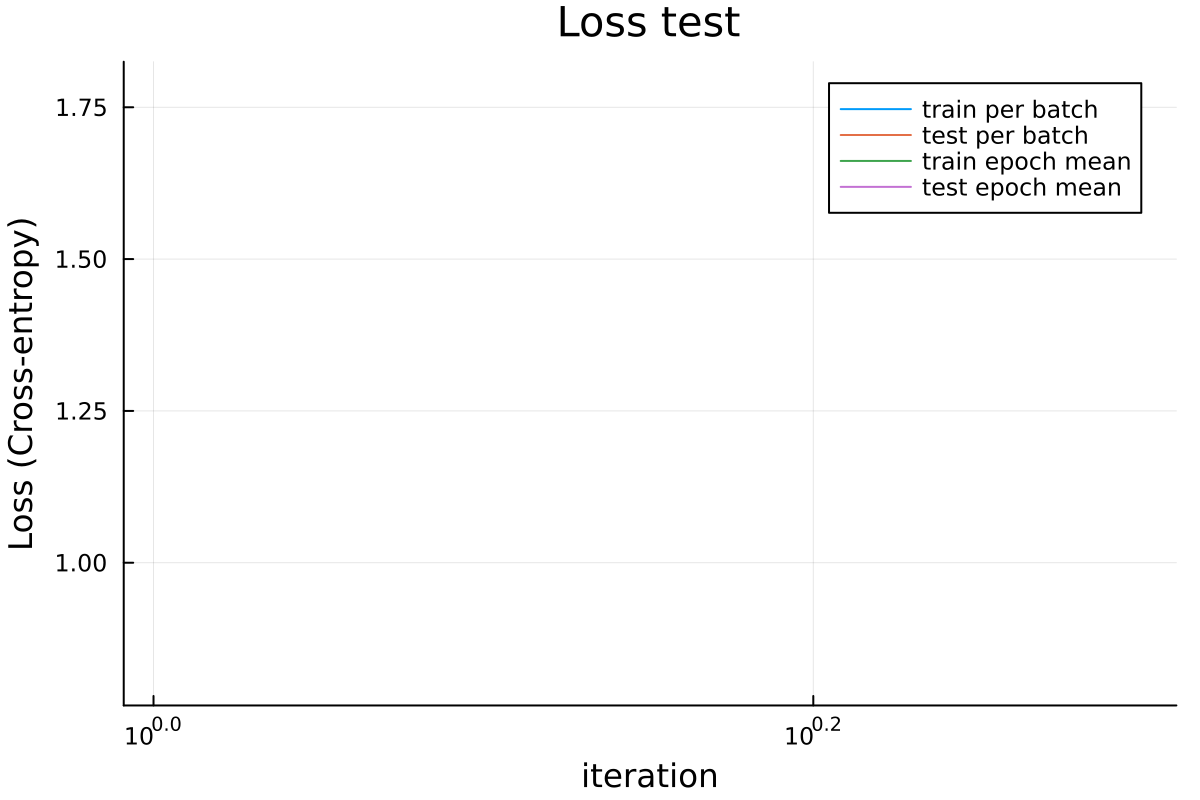

In [108]:
plot(losses; xaxis=(:log10, "Iterations"),
    yaxis="Loss (Cross-entropy)", label="train per batch")
plot!(losses_test; xaxis=(:log10, "iteration"),
    yaxis="Loss (Cross-entropy)", label="test per batch")
@show n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="train epoch mean", title="Loss train", dpi=200)
plot!(n:n:length(losses_test), mean.(Iterators.partition(losses_test, n)),
    label="test epoch mean", title="Loss test", dpi=200)

n = length(loader) = 41


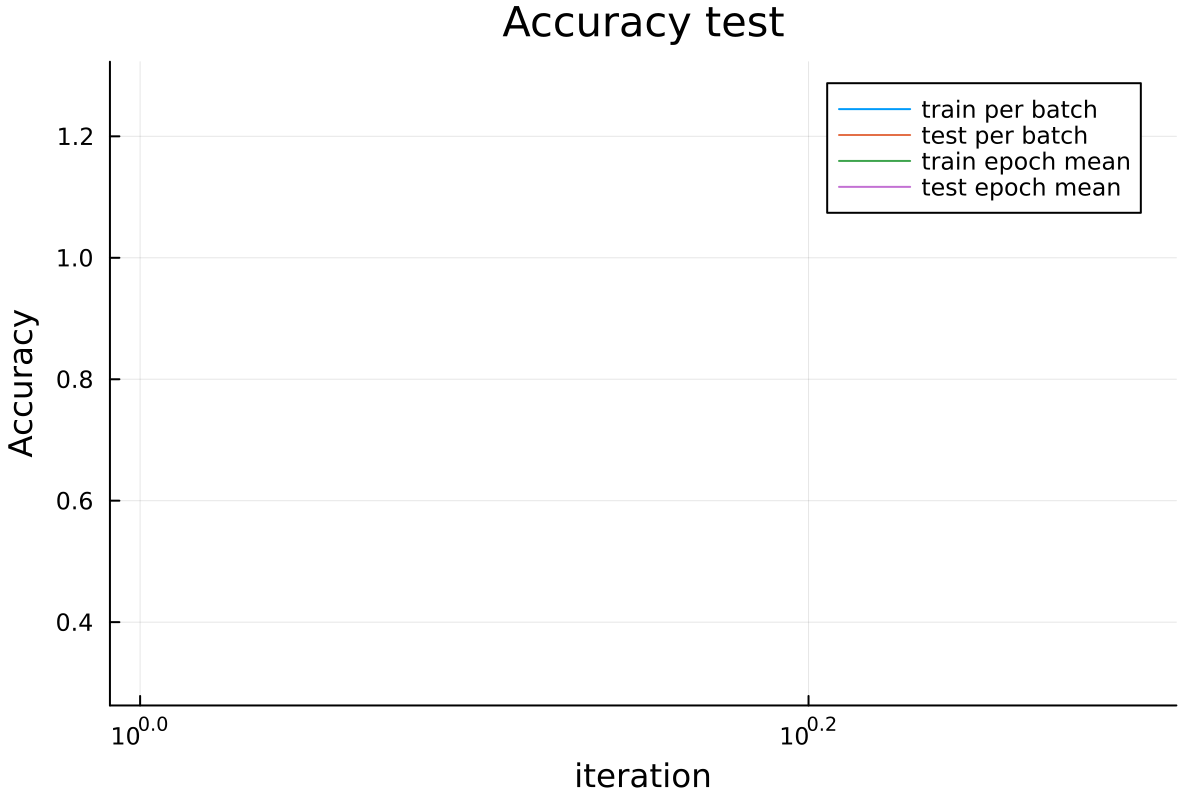

In [109]:
plot(accuracies; xaxis=(:log10, "iteration"),
    yaxis="Accuracy", label="train per batch")
plot!(accuracies_test; xaxis=(:log10, "iteration"),
    yaxis="Accuracy", label="test per batch")
@show n = length(loader)
plot!(n:n:length(accuracies), mean.(Iterators.partition(accuracies, n)),
    label="train epoch mean", title="Accuracy", dpi=200)
plot!(n:n:length(accuracies_test), mean.(Iterators.partition(accuracies_test, n)),
    label="test epoch mean", title="Accuracy test", dpi=200)

In [110]:
truth[1:10]

10-element BitVector:
 0
 0
 0
 1
 0
 0
 1
 0
 0
 0

In [111]:
Flux.onecold(target)[1:10]

10-element Vector{Int64}:
 2
 2
 2
 1
 2
 2
 1
 2
 2
 2

In [112]:
Flux.onecold(model(noisy))[1:10]

10-element Vector{Int64}:
 1
 2
 1
 1
 1
 1
 1
 1
 1
 1

In [113]:
TP = 0
TN = 0
FP = 0
FN = 0
y_cold_test = Flux.onecold(target_test)
ŷ_cold_test = Flux.onecold(model(noisy_test))
tot = length(truth_test)
for i=1:length(truth_test)
    if (labels_TF[ŷ_cold_test[i]]==true  && labels_TF[y_cold_test[i]]==true ) TP+=1 end
    if (labels_TF[ŷ_cold_test[i]]==true  && labels_TF[y_cold_test[i]]==false) FP+=1 end
    if (labels_TF[ŷ_cold_test[i]]==false && labels_TF[y_cold_test[i]]==true ) FN+=1 end
    if (labels_TF[ŷ_cold_test[i]]==false && labels_TF[y_cold_test[i]]==false) TN+=1 end    
end
@show TP/tot
@show FP/tot
@show TN/tot
@show FN/tot

DimensionMismatch: DimensionMismatch: A has dimensions (25,6) but B has dimensions (22,2593)

In [114]:
# ROC curve
y_cold_test = Flux.onecold(target_test)
ŷ_test      = model(noisy_test)
tot         = length(truth_test)
pos         = sum(truth_test.==1)
neg         = sum(truth_test.==0)
threshold   = 0.:0.1:1.0
x           = zeros(length(threshold))
y           = zeros(length(threshold))
for it=1:length(threshold)
    TP, TN, FP, FN = 0, 0, 0, 0
    thr = threshold[it]
    for i=1:length(truth_test) 
        if ( truth_test[i]==1 && ŷ_test[1,i]>thr ) TP+=1 end
        if ( truth_test[i]==1 && ŷ_test[2,i]>thr ) FP+=1 end
        if ( truth_test[i]==0 && ŷ_test[1,i]>thr ) FN+=1 end
        if ( truth_test[i]==0 && ŷ_test[2,i]>thr ) TN+=1 end 
    end  
    y[it] = TP/pos
    x[it] = FP/neg
end
plot(xlabel="False positive rate", ylabel="True positive rate", title="Receiving Operating Characteristic", aspect_ratio=1, label=:none, xlim=(0,1), ylim=(0,1))
plot!(x,y, label="Neural network")
plot!(x,x, label="Random classifier", c=:black, linestyle=:dash)

DimensionMismatch: DimensionMismatch: A has dimensions (25,6) but B has dimensions (22,2593)

In [115]:
# save
if with_cat_arr
    @save "model_test_80pc_with_cat.bson" model
else
    @save "model_test_80pc.bson" model
end